In [1]:
import os
import time
import copy

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision

assert torch.__version__ == '1.9.0+cu102', 'Please reinstall pytorch to 1.9.0.'
assert torchvision.__version__ == '0.10.0+cu102', 'Please reinstall torchvision to 0.10.0.'

In [2]:
classes = ['vertical jump', 'lateral jump', 'walk','kick left','kick right']
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
print(device)

cuda:0


In [3]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ######  ########################################################################
        # TODO: Define a simple CNN contraining Conv, Pooling, and FC layers.        #
        ##############################################################################
        

        # Block 1:         1 x 30 x 30 --> 32 x 15 x 15        
        self.conv1 = torch.nn.Conv2d(1, 32, 3,padding=1) 
        # Block 2:         32 x 15 x 15 --> 64 x 16 x 16
        self.conv2 = torch.nn.Conv2d(32, 64, 2,padding=1)
        # Block 3:         64 x 16 x 16 --> 128 x 8 x 8        
        self.conv3 = torch.nn.Conv2d(64, 128, 3,padding=1)
        # Block 4:          128 x 8 x 8 --> 256 x 4 x 4
        self.conv4 = torch.nn.Conv2d(128, 256, 3,padding=1)
        # Linear layers:   256 x 4 x 4 --> 4096 --> 4096 --> 4096 --> 5
        self.fc1   = torch.nn.Linear(256*4*4, 4096) 
        self.fc2   = torch.nn.Linear(4096, 4096) 
        self.fc3   = torch.nn.Linear(4096, 4096)
        self.fc4   = torch.nn.Linear(4096, 5)
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        
        ##############################################################################
        # TODO: Implement forward path turning an input image to class probability.  #
        # For activation function, please use ReLU.                                  #
        ##############################################################################

        # Block 1:         1 x 30 x 30 --> 16 x 15 x 15
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # Block 2:         16 x 15 x 15 --> 32 x 8 x 8
        x = F.relu(self.conv2(x))
        # Block 3:         32 x 8 x 8 --> 64 x 4 x 4
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # Block 4:         64 x 4 x 4 --> 128 x 2 x 2
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        # Linear layers:   128 x 2 x 2 --> 512 --> 1024 --> 1024 --> 10
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        return x

model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=5, bias=True)
)


In [4]:
assert os.path.exists('./model_cnn.pt'), 'train the model first'
# Load the trained model
model.load_state_dict(torch.load('./model_cnn.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=5, bias=True)
)

server on
服务器连接了auduino ,地址: ('192.168.31.228', 64266)
motion detected


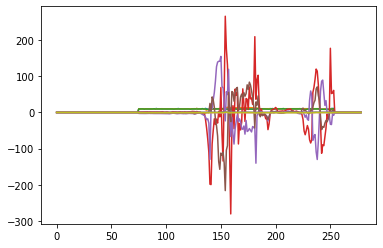

(279, 9)
154
(1, 900)


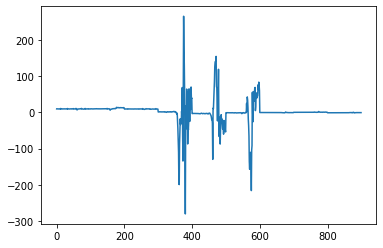

e:\#######electronic softwares######\python\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-0.0225,  0.7031, -3.1445,  1.2734,  1.2746]], device='cuda:0',
       grad_fn=<AddmmBackward>)
label= tensor([4], device='cuda:0')
the motion is: ------------> kick right


In [ ]:
def vectorgenerator(data,window):
    data=np.array(data)
#     maxval=data.max(axis=0)
#     maxtiming=data.argmax(axis=0)[maxval.argmax()]
    maxtiming=data.argmax(axis=0)[3]
    print(maxtiming)
    cut=data[maxtiming-window:maxtiming+100-window,:]
    cut=cut.T.reshape(1,900)
    return cut

import socket
import sys
import numpy as np
import matplotlib.pyplot as plt

def np_generator(str):
    arr = str.split(',')
    for i in range(len(arr)):
        arr[i]=float(arr[i])
    arr=np.array(arr)
    return arr

print("server on")
# 创建 socket 对象
serversocket1 = socket.socket(socket.AF_INET, socket.SOCK_STREAM) 
socket2 = socket.socket(socket.AF_INET, socket.SOCK_STREAM) 
# 获取本地主机名
host = socket.gethostname() #获取这个设备的名字
port1 = 1234       #指定一个端口
port2 = 8899
# 绑定端口号
serversocket1.bind((host, port1))#绑定serversocket || 主机，端口 (这个socket的服务端就是某主机的某端口了，后续就能调用相连)
# 设置最大连接数，超过后排队
serversocket1.listen(5)  #默认这么写
socket2.connect(("192.168.31.140",port2))
socket2.sendall("这句话是client发过去的".encode('utf-8'))
# must connect 2 first, otherwise stuck
#################
# for i in range(3):
#     clientsocket2,addr2 = serversocket2.accept()  
#     # 这一句就会一直阻塞，在他接受了5个请求之前，都会在这卡着，后边的whiletrue就运行不了，client1就连不上。
#     print("服务器连接了unity ,地址: %s" % str(addr2))
#     m=str(i)
#     clientsocket2.send(m.encode('utf-8'))
#     clientsocket2.close()
###################
while True:
    # 建立客户端连接
    clientsocket1,addr1 = serversocket1.accept()
    print("服务器连接了auduino ,地址: %s" % str(addr1))
    # msg1='这句话是服务器发回的send()响应'+ "\r\n"
    # msg1="服务器向你回传了消息，证明你确实已被连上"
    msg1='1'
    clientsocket1.send(msg1.encode('utf-8'))   
    c=0
    s=""
    #前接75个0 保证不越界
    data=np.zeros([75,9])
    countdown=10000
    flag=0
    while True:
        msg = str(clientsocket1.recv(1024))
        # print(len(msg))
        # print(type(msg))
        for i in range(len(msg)):
            # print(msg[i])
            if(msg[i]=='%'):
                #又得到一行：
                arr=np_generator(s).reshape(1,9)
                if arr[0][3]>150:
                    if flag==0:
                        print("motion detected")
                        flag=1
                        countdown=100
                    if flag==1:
                        flag=1
                #拼接到之前的一条data里
                data=np.concatenate((data,arr),axis=0)
                countdown=countdown-1
#                 print(countdown)
                if countdown==0:
                    #this is your data
                    #后接25个0 保证不越界
                    data=np.concatenate((data,np.zeros([25,9])),axis=0)
#                     print(data)
                    plt.figure()
                    plt.plot(data)
                    plt.show()
                    print(data.shape)
                    data=vectorgenerator(data,75)
                    print(data.shape)
                    plt.figure()
                    plt.plot(data.T)
                    plt.show()
                    #predicetion
                    input=torch.tensor(data).reshape(1,1,30,30).type(torch.FloatTensor)
                    input=input.to(device)
                    output=model(input)
                    print(output)
                    p_labels_all=torch.max(output,1)[1]
                    print("=======================================================")
                    print("label=",p_labels_all)
                    print("the motion is: ------------>",classes[p_labels_all])
                    socket2.sendall(str(p_labels_all.item()).encode('utf-8'))
                    print("=======================================================")
                    #reset everything
                    data=np.zeros([75,9])
                    flag=0
                    countdown=10000
#                 print(arr)
                s=""
            else:
                if(msg[i]!='b'):
                    if(msg[i]!='\''):
                        s=s+str(msg[i])
        c=c+1
        # print(msg.decode(),i)
    # clientsocket.close()

In [ ]:
import numpy as np
data=np.zeros([1,9])
x=np.array([1,2,3,4,5,6,7,8,9]).reshape(1,9)
a=np.concatenate((data,x),axis=0)
print(data)
print(x)
print(a)

In [ ]:
print(label)